In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
from keras.datasets import mnist
import keras.backend as K
from keras.layers import Dense, Reshape, Flatten, Input, Dropout, Lambda,ELU,Activation
import keras.losses as losses
import keras.objectives as objectives
from keras.optimizers import Adam,SGD 
import keras.metrics as metrics
from keras.models import Model
from functools import reduce
from operator import mul
from sklearn.model_selection import train_test_split
from ipywidgets import interact
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import ipywidgets as ipy
import matplotlib.pyplot as plt
from keras.layers import LeakyReLU
import numpy as np
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.callbacks import ModelCheckpoint

%matplotlib inline

/home/qati/.anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1]*x_train.shape[2]))/255.
x_test =  x_test.reshape((x_test.shape[0], x_test.shape[1]*x_test.shape[2]))/255.

In [4]:
X_train, X_validation, Y_train, Y_validation = train_test_split(x_train, y_train, test_size=0.1, random_state=432554)

In [5]:
np.max(X_train)

1.0

In [6]:
latent_dim=10

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

def build_vae(input_shape, lrelu=0.1, layer_sizes=[500,200]):
    n = reduce(mul,input_shape,1)
    
    #encoder
    pic = Input(shape=(n,))
    x = Dense(n)(pic)
    x = LeakyReLU(lrelu)(x)
    for ls in layer_sizes:
        x = Dense(ls)(x)
        x = LeakyReLU(lrelu)(x)

    z_mean = Dense(latent_dim)(x)
    z_log_sigma = Dense(latent_dim)(x)
    
    encoder = Model(inputs=pic, outputs=[z_mean, z_log_sigma])
    encoder.summary()
        
    #decoder
    z_mean_d  = Input((latent_dim,))
    z_log_std_d = Input((latent_dim,))
    
    z = Lambda(sampling)([z_mean_d, z_log_std_d])

    x  = Dense(layer_sizes[-1])(z)
    x  = LeakyReLU(lrelu)(x)
    for ls in reversed(layer_sizes[:-1]):
        x = Dense(ls)(x)
        x  = LeakyReLU(lrelu)(x)
    x = Dense(n)(x)
    x  = Activation("sigmoid")(x)
    decoder = Model(inputs=[z_mean_d, z_log_std_d], outputs=[x])
    
    decoder.summary()

    #autoencoder
    autoencoder = Model(inputs=[pic], outputs=decoder(encoder.output))    
    
    #plot_model(autoencoder, to_file='vae_model_plot.png', show_shapes=True, show_layer_names=True)
    
    return encoder, decoder, autoencoder

In [7]:
def vae_loss(encoder):
    z_mean, z_log_sigma = encoder.output
    def run(x, x_decoded_mean):
        bl_loss = objectives.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 5e-4 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
        return K.mean(bl_loss + kl_loss)
    return run

## 10D latent space

In [8]:
encoder, decoder, autoencoder = build_vae([28,28], 0.1, layer_sizes=[512,256,128,64,32,16,10])
autoencoder.compile(loss=vae_loss(encoder), optimizer='rmsprop')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 784)          615440      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 784)          0           dense_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 512)          401920      leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [12]:
save = ModelCheckpoint("vae_simple_mnist.h5", monitor='loss', verbose=0, save_best_only=True,period=2)
history = autoencoder.fit(X_train, X_train,  epochs=50, batch_size=256, callbacks=[save])

Epoch 1/50
54000/54000 [==============================] - 4s 68us/step - loss: 0.2986
Epoch 2/50
54000/54000 [==============================] - 3s 57us/step - loss: 0.2281
Epoch 3/50
54000/54000 [==============================] - 3s 54us/step - loss: 0.2072
Epoch 4/50
54000/54000 [==============================] - 3s 56us/step - loss: 0.1910
Epoch 5/50
54000/54000 [==============================] - 3s 53us/step - loss: 0.1811
Epoch 6/50
54000/54000 [==============================] - 3s 56us/step - loss: 0.1742
Epoch 7/50
54000/54000 [==============================] - 3s 55us/step - loss: 0.1694
Epoch 8/50
54000/54000 [==============================] - 3s 58us/step - loss: 0.1659
Epoch 9/50
54000/54000 [==============================] - 3s 54us/step - loss: 0.1630
Epoch 10/50
54000/54000 [==============================] - 3s 56us/step - loss: 0.1606
Epoch 11/50
54000/54000 [==============================] - 3s 54us/step - loss: 0.1585
Epoch 12/50
54000/54000 [===========================

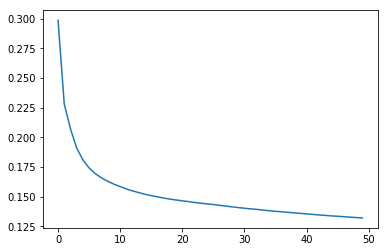

In [13]:
plt.plot(history.history["loss"])
#plt.plot(history.history["val_loss"])

In [14]:
E_test = encoder.predict(x_test)
D_test = decoder.predict(E_test)
D_test = D_test.reshape((D_test.shape[0],28,28))

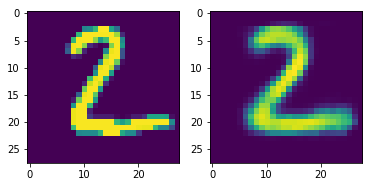

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2)#, sharey=True, sharex=True)
i=1
ax1.imshow(x_test.reshape((-1,28,28))[i,:,:])
ax2.imshow(D_test[i,:,:])

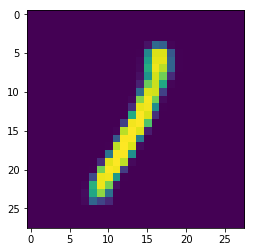

In [22]:
E_rand_mean = np.random.randn(10,10)
E_rand_std = np.random.randn(10,10)

D_rand = decoder.predict([E_rand_mean, E_rand_std])
D_rand = D_rand.reshape((10,28,28))
plt.imshow(D_rand[6,:,:])

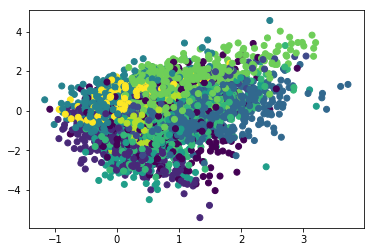

In [23]:
plt.scatter(E_test[0][:,0], E_test[0][:,4], c=y_test.astype(np.float))

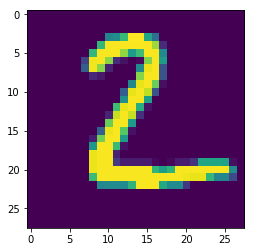

In [58]:
plt.imshow(x_test[1].reshape((28,28)))

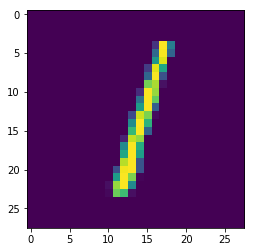

In [60]:
plt.imshow(x_test[2].reshape((28,28)))

In [59]:
enc_of2_mean = E_test[0][1,:]
enc_of2_std = E_test[1][1,:]
def plot(x,y):
    enc_mean = x*E_test[0][2,:].reshape((1,-1))+(1-x)*enc_of2_mean
    enc_std = y*E_test[1][2,:].reshape((1,-1))+(1-y)*enc_of2_std
    dec = decoder.predict([enc_mean, enc_std])
    dec = dec.reshape((28,28))
    plt.imshow(dec)
    plt.show()
    
interact(plot,x=(-1,1,0.01),y=(-1,1,0.01))

interactive(children=(FloatSlider(value=0.0, description='x', max=1.0, min=-1.0, step=0.01), FloatSlider(value=0.0, description='y', max=1.0, min=-1.0, step=0.01), Output()), _dom_classes=('widget-interact',))

<function __main__.plot>